In [1]:
using PyPlot
using PyCall
using Printf
@pyimport matplotlib.animation as anim
@pyimport matplotlib.patches as patches

In [2]:
using Base64
function showanim(filename)
    base64_video = base64encode(open(filename))
    display("text/html", """<video controls src="data:video/x-m4v;base64,$base64_video">""")
end

showanim (generic function with 1 method)

In [3]:
mutable struct World
    objects
    debug
    time_span
    time_interval
    ani
end

World() = World([], false, 10, 1, nothing)
World(debug) = World([], debug, 10, 1, nothing)
World(time_span, time_interval) = World([], false, time_span, time_interval, nothing)

function append(self::World, obj)
    push!(self.objects, obj)
end

function init_draw(self::World, ax)
    ax.set_aspect("equal")
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5)
    ax.set_xlabel("X", fontsize=20)
    ax.set_ylabel("Y", fontsize=20)
end

function draw(self::World)
    fig, ax = subplots()
    init_draw(self, ax)    
    elems = []

    if self.debug
        for i = 1:1000
            one_step(self, i, elems, ax)
        end
    else
        self.ani = anim.FuncAnimation(fig, one_step, fargs=(self, elems, ax), 
            frames = Int(self.time_span/self.time_interval)+1, interval = Int(self.time_interval*1000))
        self.ani[:save]("test.mp4", bitrate=-1, extra_args=["-vcodec", "libx264", "-pix_fmt", "yuv420p"])
    end 
    
end

function one_step(i,self::World,elems, ax)
    plt.cla()
    init_draw(self, ax)
    while length(elems) > 0
        pop!(elems)
    end
    vcat(elems, ax.text(-4.4, 4.5, string("t = ", @sprintf("%.2f[s]", self.time_interval * i) ), fontsize=10))
    for obj in self.objects
        draw(obj, ax, elems)
        one_step(obj, 1.0)
    end
end

one_step (generic function with 1 method)

In [4]:
mutable struct Agent
    nu
    omega
end
function decision(self::Agent, observation=nothing)
    return self.nu, self.omega
end

decision (generic function with 2 methods)

In [5]:
mutable struct IdealRobot
    pose
    r
    color
    agent
    poses
end

IdealRobot(pose) = IdealRobot(pose, 0.2, "black", nothing, [pose])
IdealRobot(pose, color) = IdealRobot(pose, 0.2, color, nothing, [])
IdealRobot(pose, agent) = IdealRobot(pose, 0.2, "black", agent, [pose])
IdealRobot(pose, agent, color) = IdealRobot(pose, 0.2, color, agent, [pose])

function draw(self::IdealRobot, ax, elems)
    x,y,theta = self.pose
    xn = x + self.r * cos(theta)
    yn = y + self.r * sin(theta)
    elems = vcat(elems, ax.plot([x, xn], [y,yn], color = self.color))
    c = patches.Circle(xy=(x,y), radius = self.r, fill = false, color = self.color)
    elems = vcat(elems, [ax.add_patch(c)])
    
    push!(self.poses, self.pose)
    elems = vcat(elems, ax.plot([e[1] for e in self.poses], [e[2] for e in self.poses], linewidth=0.5, color="black"))
end

function state_transition(self::IdealRobot, nu, omega, time)
    t0 = self.pose[3]
    if abs(omega) < 1e-10
        return self.pose + [nu*cos(t0), nu*sin(t0), omega].*time
    else
        return self.pose + [nu/omega*(sin(t0+omega*time)-sin(t0)),
                                  nu/omega*(-cos(t0+omega*time)+cos(t0)),
                                 omega*time]
    end
end

function one_step(self::IdealRobot, time_interval)
    if isnothing(self.agent)
        return
    end
    nu, omega = decision(self.agent)
    self.pose = state_transition(self, nu, omega, time_interval)
end

one_step (generic function with 2 methods)

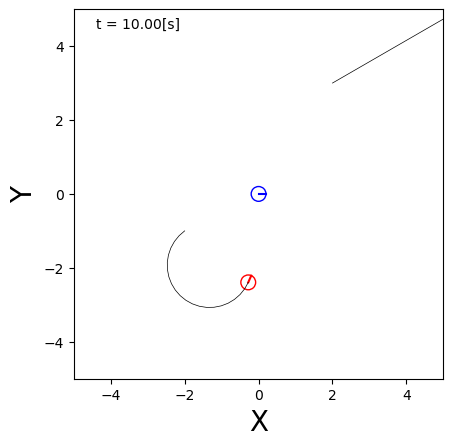

In [6]:
world = World(10, 0.5)
straight = Agent(0.2, 0.0)
circling = Agent(0.2, 10.0/180*pi)
robot1 = IdealRobot([2, 3, pi/6], straight)
robot2 = IdealRobot([-2, -1, pi/5*6], circling, "red")
robot3 = IdealRobot([0,0,0], nothing, "blue")
append(world, robot1)
append(world, robot2)
append(world, robot3)
draw(world)

In [26]:
showanim("test.mp4")

<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAAOHBtZGF0AAACoAYF//+c3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1NyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMTggLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MiBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAADhlliIQAFv/+99M/zLLr9zm146j3op4mX0N1JQGblsTtOoAAAAMAAAMAAB68FghEPzIoq68AAAMAyoAXqEf/CmOPgAS+o/4U+3GcjnaQCVQrSiMBHWa7/x8xHwnGftHIjEI+CaLXGu4OdilRzg+3WJ5/X/yOnu2raA1CBBfiYP2q5fTTcV7SODiWT5HWS5Z0XWgXo/gnB9zXNGz7seKd3jgxv/UU3zoLNdeyNEdF7fO8D3HC0qRelCNjddX/7zbzjotT0pu7SF7YLubnfMtdpE3zEyZVWX4TX/vFThjIHL/MAHy0PuHUT2rXL0tW32lOdUmoKI1/EDolGXqaFTgZIO6rTgsJfN616ER2UOZQHdsZDFSuSkX29e97p9tmOu78RFZzy4Jgs3WC/ehqe3WVa2Gb1rp2BDfJc0dKcj3+waBX6pAVk+B+T3kuymbuIQtJbi7EvRjLUAdRRgPP5sUgNaxqArqfFtw0IESd+YMkMdRWQDHsMzoE+c8bWHKsc6xl06Hc2AvhcxP8c7yItLrb3g/DPQTc67LBBZyFsP8ZyMEFc5Jo9bvAnbknPt0sH/PfZoC5tzBB4QZbJ/BESORYP4D3zZ7cmOgVZSW9D0PGOJqfIJABvIne+0ylAsAXFGfPW3f/wZVHum/f4lCvBZ+LUzu3z+Vl9i1hRPHaE34fgSjp/CejVH7Xi9TUxgfM8gH4RJblL2sJerWpruiYGtipKouTFu7AJi17+lKIe3Obbz5d9kqUj0g0Jv8llsMsbTpESL5nwBkDdDr4PGhdxQQUG1q04etZ55e9iLUd5yjpv+yj8TypX2on3EKhgOi81yE8bWuA7MvqaYt65B/quYVSrKdCkY4yqGIjH7mVp0kLPiJMVhkKebyoWJRsAr9MEA3NQpbsOJhcq3DmtkGotRgYblr8CWQxtNGT8CgTMFG+dnhUoO+dXJLD+vLPC5vtPxvYA/lWIp1m3qN2T+XECnFsqKJIee8tHcweDEydR+iAwPRmE72ZxNDkLdnO3vNIlxDpzweq81ZykBVktel+V08vFRf5rFLHnITz30JATgx2o1yE/pVbp3WCOK4G/gEVHzrFiO9iRENIT+72q62uM/pp+Y/AEOuBPKqS1dmW1vGN2+qMZG1ES11mXS1x39A868bKZMJqECax0RWvAG2mrnHlDzxMtkuRnK/hza76CBrW3QytETxW4WJZ6U9ict8GNTRbbWByk0x/d9B48l8O0q1NSDlbnTMeRZetpIsyF7IAd2IPCU9hkWjVs3XVxTtr7BgETnRDlbi/S6NSKF0jqsWFXxGBrpGWOc2d4+r8f7M1UF8oxGqUXvqpLOctdvAntsQxqaeNPSyhrpNjZR3TuNWA1Qp1Xv+tZogPlKXmr4eYeGvdL7OnarHnHBI7sQG0uhNe0niA3Y6hcUaNdOTUR6E5AU2h3l3cZB9dR77zOuYYY6eook11GbrEbuhag9In6vxlwHHkARcTrcCaJFCHgJaCUz7m0V8XCxB8NXcYQ8UaZCJwbqESppY1lnKQ6byLnjQLiPD4yvMt/oeKZNcvCEBKpeY9VjGTqu0iVMfcjNHAiolBZ1MPvuL8X4jJLA5YJ1cHbYVRWrQzjMoPoGVKBYKYfVQZu9zpNEPp8I+MVRxTvxW/w5NnxLICyPsVCJpipwQryd/9NiKhDU5hwxlj3cVPKaQua3NarRRO2oWLQRjO9pSXJiS2Tm4lfzkkm0i4rglzLZPvyshvgevnPqYT6badIfR22wbL1rZfUmKGLNxQetfCx5TikPjuxVQzDzMZSO/TfYWApxiA6wXp60LmJ8StAItzabVNamLKS8rNAolDFenWcykPWbyluAbgKDKdDYWfZL0fjeDNRAU9/I5SltNdYAB35NCy/wDqoNagfavUVoibQC7dSEPc5lukOGNIv8ldpaN7oOmiAbfz9IZ/Ke2kFX8cAeatkEsNdZiaQP+E+xEVH8Ap2lYPYEy0ifPpnZE/NB9LZyWehhBU2NZp8SyuaTvup9z3ssPaLpkq65QiEbkFyITkydJbzaQKgeVFDoRQ79r/NQXmDMao3dYf9kEiODZrGbpeqS9Eel3XwxISaBM3psYSE3FtPQGD37y4LgMeCTWQ2Vq1jwQkoB7iXAx0Xne2j59ndxfxowu8Ge+q88znBRursgUeOt9kb5uMJALOiM+vwYgVGrvtxrNMxeO9yxDm2Mtn5scgzHVEUv2c+vFQZYcWH/PAdu0kkWv6O0oH8YT+vSqfmw5BFtYTldOJno4fxRq4/d66VRbvYZWfB/zuDe2VGNBLWU79SLxO9eLBuGux/Xp+cyjED6UoXxP24Y+6hUd3hCgQaq3jeNlX3MA/ynH4NgBtxP9AR2gKw5QUoGk9SGYweHbWBVdwRsgB1nsuo+mQzHAgQ1OZACNM286cejnRauba6vpvB1ZiFhvlNxNBgMBc5RYnpcTUYyhTQ64SKbh9xvvjRft/A6IMi6Lyb8DDyFcq6wN3AHZYDiQ0jpZAgnSga9Pg6NO9uoiSBKDsF/9dgNiIWH3Fd5htUWC2czCtgdKW5D5/RwkIqTiz+9678AAbpH0yHir5xbzO/9pFyS5liPw8NYRK/cJC+C0o1IFn+24LmRSQ99ieZq2JixmcUp7sx+OUmfBNR0g4s816w8uG9s3jz5TvWExTXTVOaaXtMRG3ecl4Jg7zYWFcBdJph474X5GlK3wUy4Wv6vtrdwmfWZ+MjJmJLWoJxTtq7D23XEnB1ATGb8xBmlhTzrLrqC8Rj8vz9a98yQh6PsKuYsmWGgZ6nClchP7Z9F2JYHe4BzGoYb8KVRLEWIuHmol6g+pMEil6oXe1A1bj81dTD7yDiFZX73pTBic/yawLsDhmIqHJli3pgRqCYwx/zaNYcMBLFrabiONxOfkcgeffWdrNBpI2QO5pPdFboEk4zeRNIj0tk0+927O+HXOvliygJthhbg+DaLTh0s5aKgue1+MR9tJa2fugMUKKCfS